# Example: Random KS model (we just take any with Picard Rank 2)

In [1]:
# some general packages
import numpy as np
import os
import pickle

# ML packages
import tensorflow as tf

# data generation
from cymetric.pointgen.pointgen_mathematica import ToricPointGeneratorMathematica
from cymetric.pointgen.nphelper import prepare_dataset, prepare_basis_pickle
from cymetric.models.tfhelper import prepare_tf_basis

# training
from cymetric.models.tfmodels import PhiFSModelToric
from cymetric.models.callbacks import SigmaCallback, TransitionCallback, RicciCallback, VolkCallback
from cymetric.models.metrics import SigmaLoss, TransitionLoss, RicciLoss, VolkLoss
from cymetric.models.measures import sigma_measure, transition_measure_loss, ricci_measure

## Compute toric information

In [2]:
# sage integration .restrict_to_regular_triangulations()
from cymetric.sage.sagelib import prepare_toric_cy_data

work_dir = "./ToricModel"
vertices = [[1, 0, 0, 0], [0, 1, 0, 0], [0, 0, 1, 0], [0, 0, 0, 1], [-1, -1, -1, 0], [2, 0, 0, -1]]  # P2 fibered over P2
polytope = LatticePolytope(vertices)
pConfig = PointConfiguration(polytope.points(), star=[0 for _ in range(len(vertices[0]))])
triangs = pConfig.restrict_to_connected_triangulations().restrict_to_fine_triangulations().restrict_to_star_triangulations([0 for _ in range(len(vertices[0]))]).triangulations_list()
triang = triangs[0]
tv_fan = triang.fan()
tv = ToricVariety(tv_fan)

toric_data = prepare_toric_cy_data(tv, os.path.join(work_dir, "toric_data.pickle"))
list(toric_data.keys())

['dim_cy',
 'vol_j_norm',
 'coeff_aK',
 'exp_aK',
 'exps_sections',
 'patch_masks',
 'glsm_charges',
 'non_ci_coeffs',
 'non_ci_exps',
 'int_nums']

## Generate points

In [3]:
work_dir = "./ToricModel"
with open(os.path.join(work_dir, 'toric_data.pickle'), 'rb') as f:
    toric_data = pickle.load(f)
num_pts       = int(100000)
precision     = int(10)
verbose       = int(1)
kmoduli       = np.ones(len(toric_data['exps_sections']))

In [4]:
mathematica_pointgen = ToricPointGeneratorMathematica(toric_data, 
                                                      kmoduli, 
                                                      precision=precision, 
                                                      verbose=verbose)

In [5]:
kappa = mathematica_pointgen.prepare_dataset(num_pts, work_dir)
prepare_basis_pickle(mathematica_pointgen, work_dir, kappa)

WolframKernel-<tcp://127.0.0.1:57298>:INFO:Connected to logging socket: tcp://127.0.0.1:57298
WolframKernel-<tcp://127.0.0.1:57298>:DEBUG:Evaluating a new expression.
pointgenMathematica:DEBUG:Running with 10 Mathematica kernels.
pointgenMathematica:DEBUG:Initializing generation of 100000 points...
WolframKernel-<tcp://127.0.0.1:57298>:INFO:Number of points on CY from one ambient space intersection: 4
WolframKernel-<tcp://127.0.0.1:57298>:INFO:Now generating 100000 points...
WolframKernel-<tcp://127.0.0.1:57298>:INFO:Generated 0% of points
WolframKernel-<tcp://127.0.0.1:57298>:INFO:Generated 5% of points
WolframKernel-<tcp://127.0.0.1:57298>:INFO:Generated 10% of points
WolframKernel-<tcp://127.0.0.1:57298>:INFO:Generated 15% of points
WolframKernel-<tcp://127.0.0.1:57298>:INFO:Generated 20% of points
WolframKernel-<tcp://127.0.0.1:57298>:INFO:Generated 25% of points
WolframKernel-<tcp://127.0.0.1:57298>:INFO:Generated 30% of points
WolframKernel-<tcp://127.0.0.1:57298>:INFO:Generated 

0

## set up NN

load in data

In [6]:
tf.get_logger().setLevel('ERROR')
data = np.load(os.path.join(work_dir, 'dataset.npz'))
toric_data = np.load(os.path.join(work_dir, 'toric_data.pickle'), allow_pickle=True)
BASIS = prepare_tf_basis(np.load(os.path.join(work_dir, 'basis.pickle'), allow_pickle=True))

set up NN callbacks (info on training process)

In [7]:
scb = SigmaCallback((data['X_val'], data['y_val']))
tcb = TransitionCallback((data['X_val'], data['y_val']))
rcb = RicciCallback((data['X_val'], data['y_val']), data['val_pullbacks'])
volkck = VolkCallback((data['X_val'], data['y_val']))
cb_list = [scb, tcb, rcb, volkck]

cmetrics = [SigmaLoss(), TransitionLoss(), VolkLoss(), RicciLoss()]

define the NN hyperparameters (wrapping everything in int() and float() is necessary in sage)

In [8]:
nfold      = int(BASIS['NFOLD'].numpy().real)
amb        = [int(6)]
n_in       = int(12)
n_out      = int(1)
n_hiddens  = [int(64), int(64), int(64)]
acts       = ['gelu', 'gelu', 'gelu']
n_epochs   = int(30)
batch_size = int(64)
alpha      = [float(1.), float(1.), float(1.), float(1.), float(1.)]

initialize the NN and the Toric Phi Model

In [9]:
model = tf.keras.Sequential()
model.add(tf.keras.Input(shape=(int(n_in))))
for n_hidden, act in zip(n_hiddens, acts):
    model.add(tf.keras.layers.Dense(n_hidden, activation=act))
model.add(tf.keras.layers.Dense(n_out, use_bias=False))

fs_model = PhiFSModelToric(model, BASIS, alpha=alpha, toric_data=toric_data)
fs_model.compile(custom_metrics=cmetrics, optimizer=tf.keras.optimizers.Adam(), loss=None)  # uses custom loss function in training step, so the argument we pass here is ignored

Check the volume normailzation of our data

In [10]:
dets = np.real(tf.linalg.det(fs_model.fubini_study_pb(tf.cast(data['X_train'], tf.float32))).numpy())
weights, omegas = data['y_train'][:,-2], data['y_train'][:,-1]
vol_k = np.mean(weights * dets / omegas)
print("Vol_K from triple intersection numbers at t1=t2=1:                ", toric_data['vol_j_norm'])
print("Vol_K from MC integration over FS metric in Kahler class t1=t2=1: ", np.round(vol_k, 2))

2022-02-15 12:08:40.903917: W tensorflow/core/platform/profile_utils/cpu_utils.cc:128] Failed to get CPU frequency: 0 Hz


Vol_K from triple intersection numbers at t1=t2=1:                 20
Vol_K from MC integration over FS metric in Kahler class t1=t2=1:  20.01


In [11]:
fs_model.get_kahler_potential(data['X_train'][:10])

<tf.Tensor: shape=(10,), dtype=float32, numpy=
array([0.31791428, 0.36093456, 0.3915063 , 0.25614372, 0.37344217,
       0.31150854, 0.30871662, 0.45086208, 0.41309604, 0.5562054 ],
      dtype=float32)>

## train NN

In [12]:
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '0'  # mostly silences TF logger
history = fs_model.fit(data['X_train'], data['y_train'], epochs=n_epochs, batch_size=batch_size, verbose=1, callbacks=cb_list)

 - Sigma measure val:      0.4515
 - Transition measure val: 561.4224
 - Ricci measure val:      6.6736
 - Volk val:               22.9315
Epoch 1/30


/Users/ruehle/venv-ml/lib/python3.8/site-packages/tensorflow/python/framework/indexed_slices.py:448: UserWarning: Converting sparse IndexedSlices(IndexedSlices(indices=Tensor("gradients/PartitionedCall_4_grad/PartitionedCall:1", shape=(None,), dtype=int64), values=Tensor("gradients/PartitionedCall_4_grad/PartitionedCall:0", shape=(None, 6), dtype=complex64), dense_shape=Tensor("gradients/PartitionedCall_4_grad/PartitionedCall:2", shape=(2,), dtype=int32))) to a dense Tensor of unknown shape. This may consume a large amount of memory.
  warnings.warn(


1407/1407 [==============================] - ETA: 0s - sigma_loss: 0.3651 - transition_loss: 1.8404 - volk_loss: 0.0063 - ricci_loss: 0.0000e+00 - Sigma measure val:      0.3534
 - Transition measure val: 412.7090
 - Ricci measure val:      5.2482
 - Volk val:               15.7818
1407/1407 [==============================] - 90s 56ms/step - sigma_loss: 0.3651 - transition_loss: 1.8404 - volk_loss: 0.0063 - ricci_loss: 0.0000e+00 - sigma_val: 0.3534 - transition_val: 412.7090 - ricci_val: 5.2482 - volk_val: 15.7818
Epoch 2/30
1406/1407 [============================>.] - ETA: 0s - sigma_loss: 0.3151 - transition_loss: 1.8387 - volk_loss: 0.0051 - ricci_loss: 0.0000e+00 - Sigma measure val:      0.3430
 - Transition measure val: 679.0187
 - Ricci measure val:      5.4692
 - Volk val:               15.1683
1407/1407 [==============================] - 80s 57ms/step - sigma_loss: 0.3150 - transition_loss: 1.8374 - volk_loss: 0.0051 - ricci_loss: 0.0000e+00 - sigma_val: 0.3430 - transition_v

 - Ricci measure val:      5.6629
 - Volk val:               16.3181
1407/1407 [==============================] - 81s 57ms/step - sigma_loss: 0.2259 - transition_loss: 2.8765 - volk_loss: 0.0034 - ricci_loss: 0.0000e+00 - sigma_val: 0.2750 - transition_val: 840.6137 - ricci_val: 5.6629 - volk_val: 16.3181
Epoch 17/30
1407/1407 [==============================] - ETA: 0s - sigma_loss: 0.2228 - transition_loss: 3.1058 - volk_loss: 0.0034 - ricci_loss: 0.0000e+00 - Sigma measure val:      0.2772
 - Transition measure val: 619.3763
 - Ricci measure val:      18.4173
 - Volk val:               16.9234
1407/1407 [==============================] - 82s 58ms/step - sigma_loss: 0.2228 - transition_loss: 3.1058 - volk_loss: 0.0034 - ricci_loss: 0.0000e+00 - sigma_val: 0.2772 - transition_val: 619.3763 - ricci_val: 18.4173 - volk_val: 16.9234
Epoch 18/30
1407/1407 [==============================] - ETA: 0s - sigma_loss: 0.2203 - transition_loss: 2.8202 - volk_loss: 0.0034 - ricci_loss: 0.0000e+00 -

## Plot the results

In [13]:
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
sns.set_style("darkgrid")

Note that vol_k val should be constant (and equal to 20.0). So in this case, it is off by 15%)

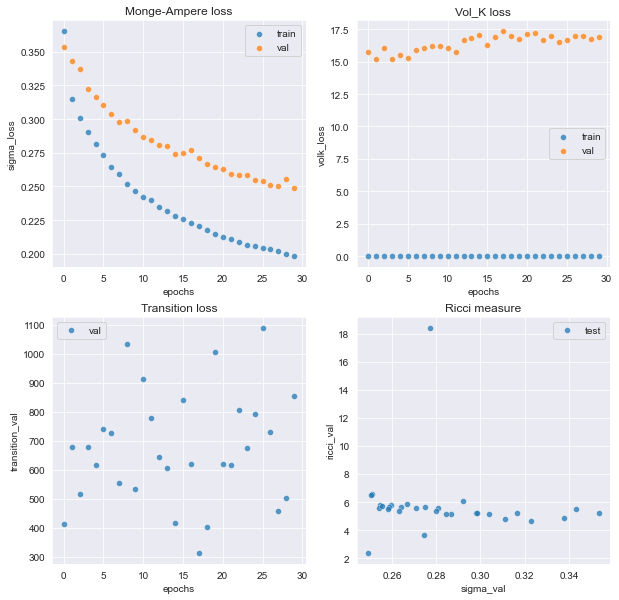

In [14]:
hist = history.history
hist['epochs'] = list(range(n_epochs))
hist_data = pd.DataFrame(hist)
fig, [[ax1, ax2], [ax3, ax4]] = plt.subplots(2, 2, figsize=(10,10));
ax1.set_title("Monge-Ampere loss")
sns.scatterplot(x='epochs', y='sigma_loss', data=hist_data, alpha=0.75, ax=ax1, label="train")
sns.scatterplot(x='epochs', y='sigma_val', data=hist_data, alpha=0.75, ax=ax1, label="val")

ax2.set_title("Vol_K loss")
sns.scatterplot(x='epochs', y='volk_loss', data=hist_data, alpha=0.75, ax=ax2, label="train")
sns.scatterplot(x='epochs', y='volk_val', data=hist_data, alpha=0.75, ax=ax2, label="val")

ax3.set_title("Transition loss")
sns.scatterplot(x='epochs', y='transition_val', data=hist_data, alpha=0.75, ax=ax3, label="val")

ax4.set_title("Ricci measure")
sns.scatterplot(x='sigma_val', y='ricci_val', data=hist_data, alpha=0.75, ax=ax4, label="test");